<div class="alert alert-info">
<h1> <b>Key Results</b> </h1>
<br>
Takes in results of Monte Carlo simulations and generates key results used in the paper. <br>
</div>

<div class="alert alert-info">
<b>Table of Contents</b> <br><br>
1. <a href="#overall">Overall access numbers</a> <br>
2. <a href="#country">Country-level data</a> <br>
3. <a href="#cycling_walking">Cycling vs walking breakdown of results</a> <br>
4. <a href="#further">Further analysis</a> <br>
</div>

In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import weightedstats as ws
from tabulate import tabulate
from scipy.stats import spearmanr, pearsonr

In [2]:
# Constants to save new results (will overwrite existing results)
SAVE_CSVS = True
SAVE_FIGURES = True

In [3]:
# Read country-level results from Monte Carlo sims
country_medians = pd.read_csv("../results/country_median_results.csv")
country_means = pd.read_csv("../results/country_mean_results.csv")
country_5th_percentiles = pd.read_csv("../results/country_5th_percentile_results.csv")
country_95th_percentiles = pd.read_csv("../results/country_95th_percentile_results.csv")

# Read district-level results from Monte Carlo sims
district_medians = pd.read_csv("../results/districts_median_results.csv")
district_means = pd.read_csv("../results/districts_mean_results.csv")
district_5th_percentiles = pd.read_csv("../results/districts_5th_percentile_results.csv")
district_95th_percentiles = pd.read_csv("../results/districts_95th_percentile_results.csv")

# Create simple one-row dataframes with global data
global_median = country_medians[country_medians["ISOCODE"] == "GLOBAL"].reset_index(drop=True)
global_mean = country_means[country_means["ISOCODE"] == "GLOBAL"].reset_index(drop=True)
global_5th_percentile = country_5th_percentiles[country_5th_percentiles["ISOCODE"] == "GLOBAL"].reset_index(drop=True)
global_95th_percentile = country_95th_percentiles[country_95th_percentiles["ISOCODE"] == "GLOBAL"].reset_index(drop=True)

# Drop global from all dataframes except _all
country_medians_all = country_medians.copy()
country_medians = country_medians[country_medians["ISOCODE"] != "GLOBAL"]
country_means = country_means[country_means["ISOCODE"] != "GLOBAL"]
country_5th_percentiles = country_5th_percentiles[country_5th_percentiles["ISOCODE"] != "GLOBAL"]
country_95th_percentiles = country_95th_percentiles[country_95th_percentiles["ISOCODE"] != "GLOBAL"]
# No need to drop from district-level dataframes as they don't have a global entry


<div class="alert alert-info">
<h3> <b>1. Overall Access Numbers </b> </h3>
<a id="overall"></a>
Overall access (walking and cycling) for the world, and select countries
</div>

Firstly, we can look at the global results for people without water access. We can also check out the breakdown by continent to compare the global impacts of infrastructure loss on freshwater access. Finally in this section we show the median breakdown by access type.

In [19]:
# Overall global population without water
global_median_percentage_without_water = global_median["percent_without_water"].values[0]
global_5th_percentage_without_water = global_5th_percentile["percent_without_water"].values[0]
global_95th_percentage_without_water = global_95th_percentile["percent_without_water"].values[0]
global_only_cycling_access = global_median["percent_with_only_cycling_access"].values[0]
global_people_without_water = global_median["country_pop_without_water"].values[0]

# Print overall results
print("GLOBAL WATER ACCESS: \n")
print(f"Global median percentage without water: {round(global_median_percentage_without_water, 1)}")
print(f"Global 5th percentile percentage without water: {round(global_5th_percentage_without_water, 1)}")
print(f"Global 95th percentile percentage without water: {round(global_95th_percentage_without_water, 1)}")
print(f"Global people without water: {round(global_people_without_water, 0)}")
print(f"Global percentage with only cycling access: {round(global_only_cycling_access, 1)}")

# Maybe add additional piped stuff here

GLOBAL WATER ACCESS: 

Global median percentage without water: 24.3
Global 5th percentile percentage without water: 14.4
Global 95th percentile percentage without water: 34.8
Global people without water: 1910216362.0
Global percentage with only cycling access: 12.0


In [5]:
# Define a function to calculate percent without water
def calculate_percent(df, group):
    data = df.groupby(group).sum()
    percent_without_water = (data['country_pop_without_water'] / data['country_pop_raw']) * 100
    return percent_without_water

# Calculate percent without water for each DataFrame
region_percent_without_water_median = calculate_percent(country_medians, "region")
region_percent_without_water_5th = calculate_percent(country_5th_percentiles, "region")
region_percent_without_water_95th = calculate_percent(country_95th_percentiles, "region")

# Merge results into a single DataFrame
region_percent_without_water = pd.DataFrame({
    'median': region_percent_without_water_median,
    '5th_percentile': region_percent_without_water_5th,
    '95th_percentile': region_percent_without_water_95th
})

# Repeat for subregions
subregion_percent_without_water_median = calculate_percent(country_medians, "subregion")
subregion_percent_without_water_5th = calculate_percent(country_5th_percentiles, "subregion")
subregion_percent_without_water_95th = calculate_percent(country_95th_percentiles, "subregion")

# Merge results into a single DataFrame
subregion_percent_without_water = pd.DataFrame({
    'median': subregion_percent_without_water_median,
    '5th_percentile': subregion_percent_without_water_5th,
    '95th_percentile': subregion_percent_without_water_95th
})

# Define formatting function
def format_results(row):
    median = round(row['median'], 1)
    p5th = round(row['5th_percentile'], 1)
    p95th = round(row['95th_percentile'], 1)
    return f"{median} ({p5th}–{p95th})"

# Apply formatting function to each row
region_percent_without_water['formatted_results'] = region_percent_without_water.apply(format_results, axis=1)
subregion_percent_without_water['formatted_results'] = subregion_percent_without_water.apply(format_results, axis=1)

# Print results
print("REGIONAL WATER ACCESS: \n")

print(region_percent_without_water.sort_values(by='median', ascending=False).to_markdown())
# print(subregion_percent_without_water.sort_values(by='median', ascending=False))

if SAVE_CSVS:
    region_percent_without_water.to_csv("../results/region_results.csv", index=True)
    subregion_percent_without_water.to_csv("../results/subregion_results.csv", index=True)

REGIONAL WATER ACCESS: 

| region   |   median |   5th_percentile |   95th_percentile | formatted_results   |
|:---------|---------:|-----------------:|------------------:|:--------------------|
| Americas |  39.1608 |         24.6435  |           54.1566 | 39.2 (24.6–54.2)    |
| Europe   |  24.6317 |         10.7033  |           42.2598 | 24.6 (10.7–42.3)    |
| Africa   |  22.7238 |         15.3329  |           30.0167 | 22.7 (15.3–30.0)    |
| Asia     |  21.3054 |         12.2023  |           31.4839 | 21.3 (12.2–31.5)    |
| Oceania  |  18.8429 |          9.01299 |           32.1743 | 18.8 (9.0–32.2)     |


<div class="alert alert-info">
<h3> <b>2. Country-level data </b> </h3>
<a id="country"></a>
Includes key results for Venezuela
</div>

Main stats for individual countries can be viewed using the following code:

In [6]:
# Create formatted country results with 90% CIs

# Read the CSV files
median_df = country_medians
p5_df = country_5th_percentiles
p95_df = country_95th_percentiles
output_file = '../results/country_CI_results.csv'

# Function to rename columns (excluding identifiers)
def rename_columns(df, suffix):
    cols = df.columns.tolist()
    rename_dict = {}
    for col in cols:
        if col not in ['ISOCODE', 'Entity', 'region', 'subregion']:
            rename_dict[col] = f"{col}_{suffix}"
    df = df.rename(columns=rename_dict)
    return df

# Rename columns in each DataFrame
median_df = rename_columns(median_df, 'median')
p5_df = rename_columns(p5_df, 'p5')
p95_df = rename_columns(p95_df, 'p95')

# Merge the DataFrames on common identifiers
df = median_df.merge(p5_df, on=['ISOCODE', 'Entity', 'region', 'subregion'])
df = df.merge(p95_df, on=['ISOCODE', 'Entity', 'region', 'subregion'])

# List of metrics to calculate CI for
metrics = [
    'percent_with_water',
    'percent_without_water',
    'percent_piped_with_cycling_access',
    'percent_piped_with_walking_access',
    'percent_with_only_cycling_access',
    # Add other metrics as needed
]

# Initialize a new DataFrame to store results
results_df = pd.DataFrame()
results_df['ISOCODE'] = df['ISOCODE']
results_df['Entity'] = df['Entity']
results_df['region'] = df['region']
results_df['subregion'] = df['subregion']

# For each metric, add median values and CI strings
for metric in metrics:
    median_col = metric + '_median'
    p5_col = metric + '_p5'
    p95_col = metric + '_p95'

    # Extract the median, p5, and p95 values
    median_values = df[median_col]
    p5_values = df[p5_col]
    p95_values = df[p95_col]

    # Add the median values as numeric columns
    results_df[metric + '_median'] = median_values

    # Create the CI string
    ci_strings = median_values.round(1).astype(str) + '% (90% CI ' + \
                 p5_values.round(1).astype(str) + '–' + \
                 p95_values.round(1).astype(str) + '%)'

    # Add the formatted string to the results DataFrame
    results_df[metric + '_CI'] = ci_strings

print("COUNTRY-LEVEL STATS: \n")
print(results_df.to_markdown())

# Save the results to a CSV file
if SAVE_CSVS:
    results_df.to_csv(output_file, index=False)

COUNTRY-LEVEL STATS: 

|     | ISOCODE   | Entity                                               | region   | subregion                       |   percent_with_water_median | percent_with_water_CI      |   percent_without_water_median | percent_without_water_CI     |   percent_piped_with_cycling_access_median | percent_piped_with_cycling_access_CI   |   percent_piped_with_walking_access_median | percent_piped_with_walking_access_CI   |   percent_with_only_cycling_access_median | percent_with_only_cycling_access_CI   |
|----:|:----------|:-----------------------------------------------------|:---------|:--------------------------------|----------------------------:|:---------------------------|-------------------------------:|:-----------------------------|-------------------------------------------:|:---------------------------------------|-------------------------------------------:|:---------------------------------------|------------------------------------------:|:-------------------

In [7]:
# sum of people without water in china and india
china = country_medians[country_medians["ISOCODE"] == "CHN"]
india = country_medians[country_medians["ISOCODE"] == "IND"]
china_people_without_water = china["country_pop_without_water"].values[0]
india_people_without_water = india["country_pop_without_water"].values[0]

print(f"China: {china_people_without_water:.1e}")
print(f"India: {india_people_without_water:.1e}")
print(f"China + India: {china_people_without_water + india_people_without_water:.1e}")

China: 3.1e+08
India: 2.6e+08
China + India: 5.6e+08


In [8]:
# For Venezuela specifically:

print("VENEZUELA COUNTRY-LEVEL STATS: \n")
print(results_df[results_df["ISOCODE"] == "VEN"][["Entity", "percent_without_water_CI"]].to_markdown())

print("\nVENEZUELA DISTRICT-LEVEL STATS: \n")
district_medians_venezuela = district_medians[district_medians["ISOCODE"] == "VEN"]
print(district_medians_venezuela[["shapeName", "percent_without_water", "district_pop_without_water"]].to_markdown())

VENEZUELA COUNTRY-LEVEL STATS: 

|     | Entity                            | percent_without_water_CI   |
|----:|:----------------------------------|:---------------------------|
| 172 | Venezuela, Bolivarian Republic of | 48.0% (90% CI 33.9–59.4%)  |

VENEZUELA DISTRICT-LEVEL STATS: 

|      | shapeName              |   percent_without_water |   district_pop_without_water |
|-----:|:-----------------------|------------------------:|-----------------------------:|
|  154 | Anzoátegui             |                 58.4681 |                  1.53507e+06 |
|  158 | Apure                  |                 27.1031 |             128824           |
|  163 | Aragua                 |                 45.0848 |             733023           |
|  280 | Barinas                |                 27.9308 |             254730           |
|  477 | Carabobo               |                 60.8522 |                  1.41067e+06 |
|  586 | Cojedes                |                 44.8185 |             1662

In [9]:
# Make a single table with the 10 countries with the highest and lowest percentage of people without access to water
country_medians_simple = country_medians[["Entity", "percent_without_water"]].copy()
top10 = country_medians_simple.nlargest(10, "percent_without_water")
bottom10 = country_medians_simple.nsmallest(10, "percent_without_water")
top_bottom = pd.concat([top10, bottom10])

print("TOP 10 COUNTRIES: \n")
print(top10.to_markdown())
print("\nBOTTOM 10 COUNTRIES: \n")
print(bottom10.to_markdown())

if SAVE_CSVS == True:
    top_bottom.to_csv("../results/top_bottom_10_countries.csv", index=False)

TOP 10 COUNTRIES: 

|     | Entity               |   percent_without_water |
|----:|:---------------------|------------------------:|
|  15 | Bahrain              |                100      |
| 134 | Qatar                |                 99.9992 |
|   3 | United Arab Emirates |                 99.9565 |
|  65 | Greenland            |                 87.3923 |
| 138 | Saudi Arabia         |                 84.0509 |
| 123 | Oman                 |                 81.2435 |
|  78 | Israel               |                 79.6931 |
|  24 | Botswana             |                 73.9168 |
| 115 | Namibia              |                 73.3393 |
|  63 | Greece               |                 69.8065 |

BOTTOM 10 COUNTRIES: 

|     | Entity                            |   percent_without_water |
|----:|:----------------------------------|------------------------:|
|  91 | Liberia                           |                 1.57851 |
| 148 | South Sudan                       |                 2.

<div class="alert alert-info">
<h3> <b>3. Cycling vs walking breakdown of results </b> </h3>
<a id="cycling_walking"></a>
Looks at how far people can walk or cycle in the model and who maintains water access by walking, cycling, or using unpiped sources.
</div>

In [10]:
med_walking = global_median["weighted_med_walking"][0]
p5_walking = global_5th_percentile["weighted_med_walking"][0]
p95_walking = global_95th_percentile["weighted_med_walking"][0]

med_cycling = global_median["weighted_med_cycling"][0]
p5_cycling = global_5th_percentile["weighted_med_cycling"][0]
p95_cycling = global_95th_percentile["weighted_med_cycling"][0]

print("WALKING AND CYCLING DISTANCES: \n")

print(f"Global median walking distance: {round(med_walking, 1)} ({round(p5_walking, 1)}–{round(p95_walking, 1)}) km")
print(f"Global median cycling distance: {round(med_cycling, 1)} ({round(p5_cycling, 1)}–{round(p95_cycling, 1)}) km")
print(f"Ratio between median cycling and walking distances: {round(med_cycling / med_walking, 1)}")


WALKING AND CYCLING DISTANCES: 

Global median walking distance: 3.6 (1.6–6.1) km
Global median cycling distance: 11.8 (6.7–16.6) km
Ratio between median cycling and walking distances: 3.3


In [11]:
medians = country_medians_all.copy()
medians.loc[medians['Entity'] == 'Global', 'region'] = 'Global'

# calculate unpiped pop by region
medians["population_unpiped"] = medians["country_pop_with_water"] - medians["population_piped_with_access"]

# calculate global pop unpiped as sum of all rows except global
medians.loc[medians['Entity'] == 'Global', 'population_unpiped'] = medians.loc[medians['Entity'] != 'Global', 'population_unpiped'].sum()

# calculate region data
medians_unpiped = medians.groupby('region').apply(lambda x: x['population_unpiped'].sum() / x['country_pop_raw'].sum() * 100)
medians_no_access = medians.groupby('region').apply(lambda x: x['country_pop_without_water'].sum() / x['country_pop_raw'].sum() * 100)
medians_walk_access = medians.groupby('region').apply(lambda x: x['population_piped_with_walking_access'].sum() / x['country_pop_raw'].sum() * 100)
medians_bike_access = medians.groupby('region').apply(lambda x: x['population_piped_with_only_cycling_access'].sum() / x['country_pop_raw'].sum() * 100)
medians_undefined = 100 - medians_no_access - medians_walk_access - medians_bike_access - medians_unpiped

medians_regions = pd.DataFrame(
    {
        'region': medians_no_access.index,
        'no_access': medians_no_access.values,
        'walk_access': medians_walk_access.values,
        'bike_access': medians_bike_access.values,
        'unpiped': medians_unpiped.values,
        'undefined': medians_undefined.values,
    }
)

medians_regions.set_index('region', inplace=True)
order = ['Oceania', 'Asia', 'Africa', 'Global', 'Europe', 'Americas']
medians_regions = medians_regions.reindex(order)

print("REGIONAL BREAKDOWN OF WATER ACCESS: \n")
print(medians_regions.to_markdown())

if SAVE_CSVS:
    medians_regions.to_csv("../results/median_access_breakdown_regions.csv", index=True)

REGIONAL BREAKDOWN OF WATER ACCESS: 

| region   |   no_access |   walk_access |   bike_access |   unpiped |   undefined |
|:---------|------------:|--------------:|--------------:|----------:|------------:|
| Oceania  |     18.8429 |       42.8433 |      13.7759  |  23.3222  |   1.21562   |
| Asia     |     21.3054 |       27.8487 |      12.1954  |  38.4502  |   0.200281  |
| Africa   |     22.7238 |       13.906  |       2.92992 |  60.3627  |   0.0775779 |
| Global   |     24.3365 |       28.2397 |      12.008   |  35.5863  |  -0.170502  |
| Europe   |     24.6317 |       47.359  |      19.0578  |   8.59991 |   0.351563  |
| Americas |     39.1608 |       32.885  |      18.1051  |   9.69771 |   0.151408  |


<div class="alert alert-info">
<h3> <b>4. Further investigations </b> </h3>
<a id="further"></a>
These analyses are not explicitly included in the paper, but are useful additional context. 
 <ul>
  <li>Monte Carlo distributions of access types</li>
  <li>Model-calculated piped water rates vs national data</li>
  <li>Country populations without water rates vs piped water rates</li>
</ul> 

</div>


GLOBAL in first dataframe: False


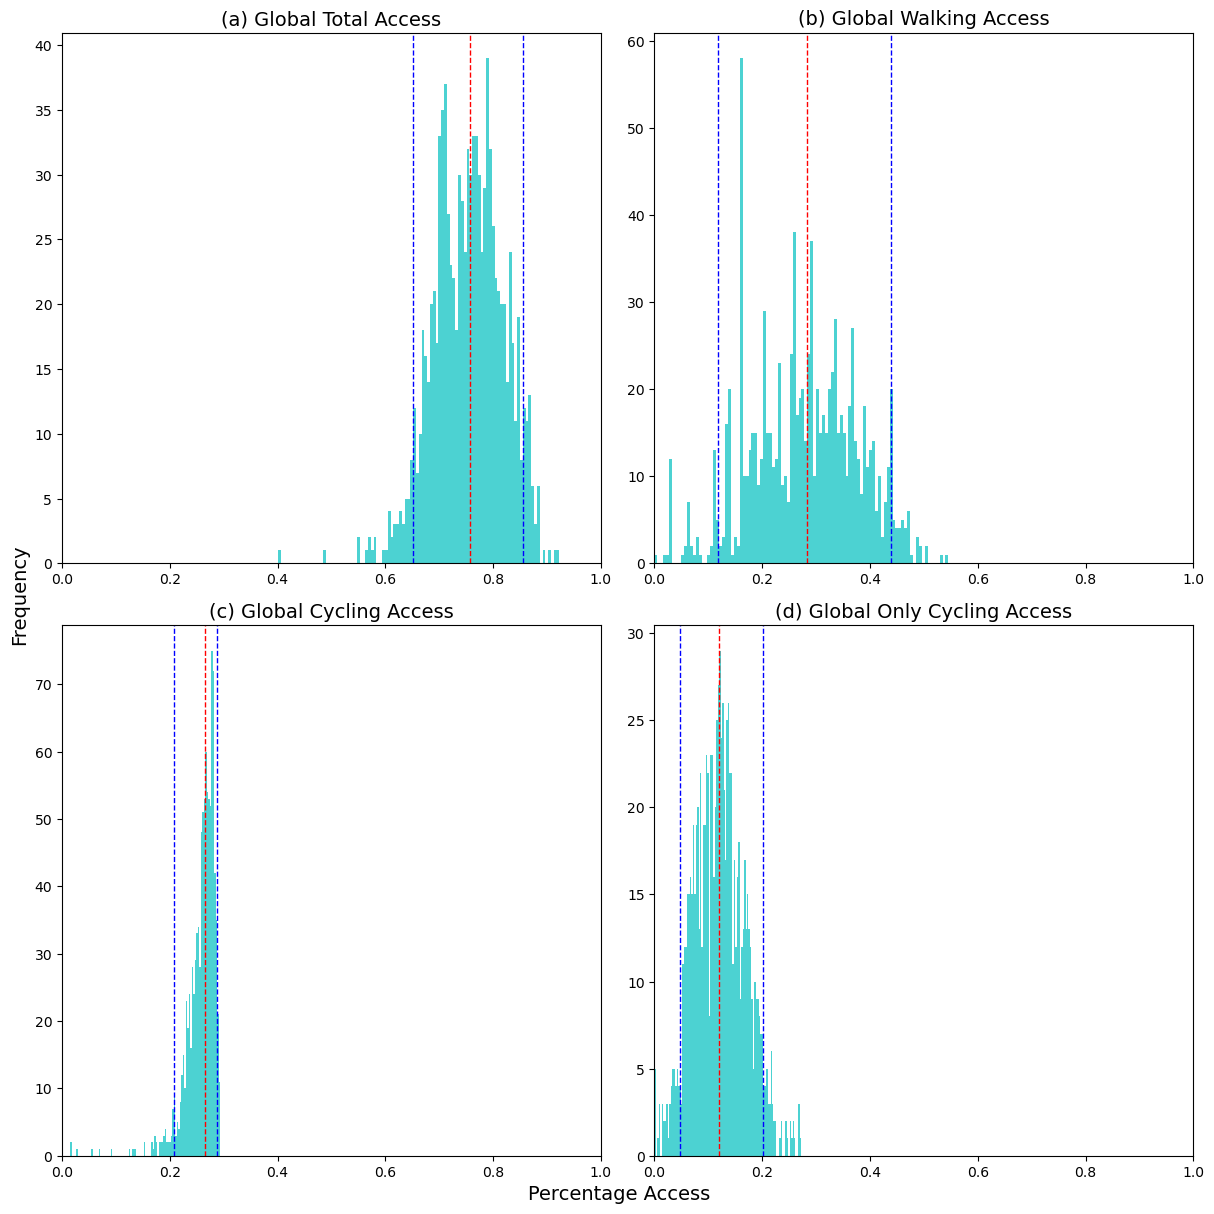

In [12]:
# Load pickled simulation results
simulation_results = pd.read_pickle("../results/countries_simulation_results.pkl")

# Drop GLOBAL from simulation results
simulation_results = [df[df.index != 'GLOBAL'] for df in simulation_results]

# Check that GLOBAL is removed from the first dataframe
print("GLOBAL in first dataframe:", 'GLOBAL' in simulation_results[0].index)

# Calculate country_pop_piped for each dataframe in simulation_results
for df in simulation_results:
    df["country_pop_unpiped"] = df["country_pop_raw"] * (100-df["NATPiped"]) / 100

# Calculate global mean percentage for each access type for each simulation using list comprehension
global_access = [df["country_pop_with_water"].sum() / df["country_pop_raw"].sum() for df in simulation_results]
global_cycling_access = [df["population_piped_with_cycling_access"].sum() / df["country_pop_raw"].sum() for df in simulation_results]
global_walking_access = [df["population_piped_with_walking_access"].sum() / df["country_pop_raw"].sum() for df in simulation_results]
global_only_cycling_access = [df["population_piped_with_only_cycling_access"].sum() / df["country_pop_raw"].sum() for df in simulation_results]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Flatten axs for easy iteration
axs = axs.flatten()

# List of access types
access_types = [global_access, global_walking_access, global_cycling_access, global_only_cycling_access]

# List of titles
titles = ["(a) Global Total Access", "(b) Global Walking Access", "(c) Global Cycling Access", "(d) Global Only Cycling Access"]

# Plot histogram of results for each access type
for i, ax in enumerate(axs):
    # Calculate median, 5th percentile, and 95th percentile
    median = np.median(access_types[i])
    p5 = np.percentile(access_types[i], 5)
    p95 = np.percentile(access_types[i], 95)

    ax.hist(access_types[i], bins=100, alpha=0.7, color='c')
    ax.set_xlim(0, 1)

    # Add vertical lines for median, 5th percentile, and 95th percentile
    ax.axvline(median, color='red', linestyle='dashed', linewidth=1)
    ax.axvline(p5, color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(p95, color='blue', linestyle='dashed', linewidth=1)

    # Set title and labels
    ax.set_title(f"{titles[i]}", fontsize=14)

# Set common x-axis label
fig.text(0.5, 0.0, 'Percentage Access', ha='center', va='center', fontsize=14)
fig.text(0.0, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
if SAVE_FIGURES == True:
    plt.savefig("../results/mc_distribution_total_access.png")
plt.show()

In [13]:
country_medians["percent_piped_with_access"] = country_medians["population_piped_with_access"] / country_medians["country_pop_raw"] * 100
country_medians["piped_calculated"] = country_medians["percent_without_water"] + country_medians["percent_piped_with_access"]
country_5th_percentiles["percent_piped_with_access"] = country_5th_percentiles["population_piped_with_access"] / country_5th_percentiles["country_pop_raw"] * 100
country_5th_percentiles["piped_calculated"] = country_5th_percentiles["percent_without_water"] + country_5th_percentiles["percent_piped_with_access"]
country_95th_percentiles["percent_piped_with_access"] = country_95th_percentiles["population_piped_with_access"] / country_95th_percentiles["country_pop_raw"] * 100
country_95th_percentiles["piped_calculated"] = country_95th_percentiles["percent_without_water"] + country_95th_percentiles["percent_piped_with_access"]

fig = px.scatter(
    country_medians, x="NATPiped", y="piped_calculated", 
    labels={'x':'NATPiped', 'y':'Piped Calculated'}, 
    title="Relationship between model-calculated piped water rates and national data on piped water rates",
    # size="bubble_size",
    color="region",
    hover_data=['Entity']
).update_layout(
    width=1200,
    height=800,
).update_xaxes(
    range=[0, 105]
).update_yaxes(
    range=[0, 105]
)

fig.show()

In [14]:
# Calculate Spearman's and Pearson's correlations
correlation_spearman, p_value_spearman = spearmanr(country_medians["NATPiped"], country_medians["piped_calculated"])
correlation_pearson, p_value_pearson = pearsonr(country_medians["NATPiped"], country_medians["piped_calculated"])

print(f"Spearman's rank correlation between national piped data and calculated piped rates in the model: {correlation_spearman:.4f} (p-value: {p_value_spearman:.4e})")
print(f"Pearson's correlation between national piped data and calculated piped rates in the model: {correlation_pearson:.4f} (p-value: {p_value_pearson:.4e})")


Spearman's rank correlation between national piped data and calculated piped rates in the model: 0.9687 (p-value: 1.2767e-109)
Pearson's correlation between national piped data and calculated piped rates in the model: 0.9441 (p-value: 1.0102e-87)


In [15]:
# create bubble size column with square root transformation for improved visuals
country_medians["bubble_size"] = country_medians["country_pop_raw"] **0.5

px.scatter(
    country_medians, 
    y="percent_without_water", 
    # x="NATPiped", 
    x="piped_calculated", 
    size="bubble_size", 
    color="region", 
    hover_name="Entity", 
    # title="Access to Water vs. Piped Water vs. Population",
).update_layout(
    yaxis_title="Country population without access to water (%)",
    xaxis_title="Country piped water access (%)",
    legend_title="Region",
    width=1200,
    height=800,
    font=dict(size=25),
    # xaxis_tickangle=-45,
    # yaxis=dict(tickfont=dict(size=2)),
    # title=dict(font=dict(size=20)),
).update_xaxes(range=[0, 105]).update_yaxes(range=[0, 105])